# Exploration of the resulting cropped images of size

In [ ]:
import glob
import json
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
# from torchmetrics import JaccardIndex, F1Score
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
os.makedirs("training_data/data3d/train/cts", exist_ok=True)
os.makedirs("training_data/data3d/train/masks", exist_ok=True)
os.makedirs("training_data/data3d/val/cts", exist_ok=True)
os.makedirs("training_data/data3d/val/masks", exist_ok=True)

In [ ]:
def crop_and_pad_image(image, slope_start, intercept_start, slope_end, intercept_end):

    target_depth = 256
    N = image.shape[2]

    # Horizontal and vertical cropping
    cropped_image = image[129:129+target_depth, 168:168+target_depth, :]

    # Calculation of start and end depth indices
    start_pred = slope_start * N + intercept_start
    end_pred = slope_end * N + intercept_end
    start_pred = int(np.round(start_pred))
    end_pred = int(np.round(end_pred))
    # print("start_pred, end_pred", start_pred, end_pred)   ########################

    # Check and adjust values so that the difference is equal to 256
    pancreas_depth_pred = end_pred - start_pred
    # print("pancreas_depth_pred", pancreas_depth_pred)   ########################

    if N >= target_depth:

        if pancreas_depth_pred < target_depth:
            diff = target_depth - pancreas_depth_pred
            half_diff = diff // 2
            start_pred = max(0, start_pred - half_diff)
            end_pred = min(N, end_pred + (diff - half_diff))

            # Rechecking after correction
            pancreas_depth_pred = end_pred - start_pred

            # If still not equal to 256, let's refine it
            if pancreas_depth_pred < target_depth:
                if start_pred == 0:
                    end_pred = target_depth
                if end_pred == N:
                    start_pred = N - target_depth

            # print("start_pred, end_pred", start_pred, end_pred)   ########################

        elif pancreas_depth_pred > target_depth:
            diff = pancreas_depth_pred - target_depth
            start_pred = diff // 2
            end_pred = diff - start_pred

        depth_cropped_image = cropped_image[:, :, start_pred:end_pred]

    else:
        # If there are not enough layers, we add zero padding
        depth_cropped_image = np.zeros((256, 256, target_depth), dtype=image.dtype)
        padding_needed = target_depth - N
        ratio = 1.84    # The pancreas is located approximately in the first third of the images (see data exploration)
        front_padding_idx = int(padding_needed / (1 + ratio)) + 1
        back_padding_idx = target_depth - (padding_needed - front_padding_idx)
        depth_cropped_image[:, :, front_padding_idx:back_padding_idx] = cropped_image[:, :, :]

    return depth_cropped_image

In [ ]:
def create3d(patient_path: str,
             split_group: str,
             regression_line_parameters: tuple[float, float, float, float]
             ) -> tuple[str, str]:

    data = np.load(patient_path)
    image = data["image"]
    mask = data["mask"]

    slope_start, intercept_start, slope_end, intercept_end = regression_line_parameters

    assert image.shape == mask.shape, f"{patient_path} Размерность изображения и маски должна быть одинаковая"

    patient_id = os.path.split(patient_path)[1].split(".")[0]

    # print("image.shape", image.shape)   #########################################
    # Stack 3D slices and convert them into torch tensors
    image_cropped = crop_and_pad_image(image, slope_start, intercept_start, slope_end, intercept_end)
    assert image_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {image_cropped.shape}"

    mask_cropped = crop_and_pad_image(mask, slope_start, intercept_start, slope_end, intercept_end)
    assert mask_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {mask_cropped.shape}"

    image_cropped = np.transpose(image_cropped, axes=(2, 0, 1))  # -> (D x H x W)
    mask_cropped = np.transpose(mask_cropped, axes=(2, 0, 1))  # -> (D x H x W)

    image_cropped = torch.as_tensor(image_cropped)
    image_cropped = image_cropped.type(torch.FloatTensor)
    mask_cropped = torch.as_tensor(mask_cropped)

    desired_height = 128
    current_height = image_cropped.shape[1]
    height_factor = desired_height / current_height

    desired_width = 128
    current_width = image_cropped.shape[2]
    width_factor = desired_width / current_width

    desired_depth = 128
    current_depth = image_cropped.shape[0]
    depth_factor = desired_depth / current_depth

    # Create and save resized 3D ct tensor
    # order=1 - bi-linear interpolation
    ct_3d = ndimage.zoom(image_cropped, zoom=(depth_factor, height_factor, width_factor), order=1)
    ct_path = os.path.join("training_data", "data3d", split_group, "cts", patient_id + "_ct.pt")
    torch.save(ct_3d, ct_path)  # -> (D x H x W)

    mask_cropped = mask_cropped.numpy()
    mask_path = os.path.join("training_data", "data3d", split_group, "masks", patient_id + "_mask.pt")
    torch.save(mask_cropped, mask_path)  # -> (D x H x W)

    return ct_path, mask_path

In [ ]:
random.seed(42)
ids = [i for i in range(1, 590)]
random.shuffle(ids)
split_index = int(0.8 * len(ids))

train_ids = ids[:split_index]
val_ids = ids[split_index:]

dataset_split = {id: "train" for id in train_ids}
dataset_split.update({id: "val" for id in val_ids})

print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Total IDs: {len(dataset_split)}")

Train IDs: 471
Validation IDs: 118
Total IDs: 589


In [ ]:
print(dataset_split)

{491: 'train', 570: 'train', 149: 'train', 154: 'train', 188: 'train', 201: 'train', 231: 'train', 84: 'train', 585: 'train', 412: 'train', 444: 'train', 470: 'train', 60: 'train', 464: 'train', 378: 'train', 384: 'train', 486: 'train', 303: 'train', 417: 'train', 537: 'train', 241: 'train', 532: 'train', 316: 'train', 286: 'train', 304: 'train', 173: 'train', 179: 'train', 266: 'train', 355: 'train', 308: 'train', 427: 'train', 571: 'train', 407: 'train', 13: 'train', 93: 'train', 459: 'train', 101: 'train', 185: 'train', 22: 'train', 119: 'train', 315: 'train', 544: 'train', 514: 'train', 484: 'train', 89: 'train', 428: 'train', 405: 'train', 507: 'train', 478: 'train', 219: 'train', 450: 'train', 320: 'train', 141: 'train', 202: 'train', 401: 'train', 248: 'train', 255: 'train', 538: 'train', 262: 'train', 317: 'train', 381: 'train', 132: 'train', 372: 'train', 76: 'train', 165: 'train', 339: 'train', 156: 'train', 131: 'train', 357: 'train', 180: 'train', 177: 'train', 148: 'train'

In [ ]:
!rm -r training_data

In [ ]:
# 16 минут

patients_paths = sorted(glob.glob("drive/MyDrive/npz_files/*"))
patients_count = len(patients_paths)

data = pd.read_csv("slice_info_training_part.csv")
slope_start, intercept_start = np.polyfit(data["total_slices"], data["start_slice"], 1)
slope_end, intercept_end = np.polyfit(data["total_slices"], data["end_slice"], 1)
regression_line_parameters = (slope_start, intercept_start, slope_end, intercept_end)

for i, pth in enumerate(patients_paths):
    if (i + 1) % 50 == 0 or i == 0:
        print("Processing patient {}/{} ...".format(i + 1, patients_count))
    paths3d = create3d(pth, dataset_split[i + 1], regression_line_parameters)

Processing patient 1/588 ...
Processing patient 50/588 ...
Processing patient 100/588 ...
Processing patient 150/588 ...
Processing patient 200/588 ...
Processing patient 250/588 ...
Processing patient 300/588 ...
Processing patient 350/588 ...
Processing patient 400/588 ...
Processing patient 450/588 ...
Processing patient 500/588 ...
Processing patient 550/588 ...


(128, 128, 128) (256, 256, 256)


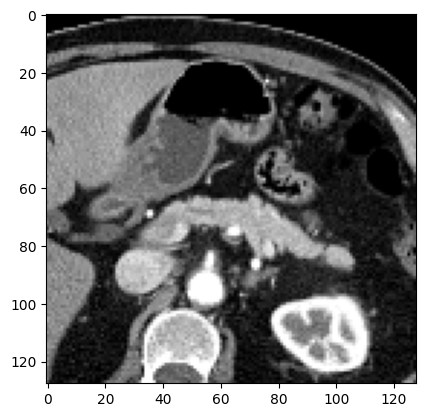

In [ ]:
import matplotlib.pyplot as plt

img = torch.load("training_data/data3d/train/cts/pancreas_0570_ct.pt")
mask = torch.load("training_data/data3d/train/masks/pancreas_0570_mask.pt")
print(img.shape, mask.shape)
plt.imshow(img[60,:,:], cmap="gray")

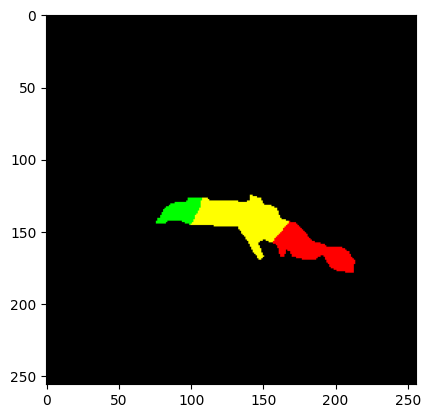

In [ ]:
rgb_images = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
rgb_images[mask == 0] = (0,0,0)
rgb_images[mask == 1] = (0,0,255)
rgb_images[mask == 2] = (0,255,0)
rgb_images[mask == 3] = (255,255,0)
rgb_images[mask == 4] = (255,0,0)
plt.imshow(rgb_images[120,:,:])

In [ ]:
import os
import torch

def check_files(directory, expected_shape_cts, expected_shape_masks):
    """
    Checking files in a given directory for compliance with expected sizes.

    :param directory: Directory with training data
    :param expected_shape_cts: Expected size for cts files
    :param expected_shape_masks: Expected size for masks files
    """
    subdirs = ["train", "val"]
    data_types = ["cts", "masks"]

    for subdir in subdirs:
        for data_type in data_types:
            path = os.path.join(directory, subdir, data_type)
            expected_shape = expected_shape_cts if data_type == "cts" else expected_shape_masks

            for root, _, files in os.walk(path):
                for file in files:
                    if file.endswith(".pt"):
                        file_path = os.path.join(root, file)
                        try:
                            data = torch.load(file_path)
                            data_shape = data.shape

                            if data_shape != expected_shape:
                                print(f"Файл {file_path} имеет размер {data_shape}, но ожидается {expected_shape}")
                        except Exception as e:
                            print(f"Ошибка при загрузке файла {file_path}: {e}")

directory = "training_data/data3d"
expected_shape_cts = (128, 128, 128)
expected_shape_masks = (256, 256, 256)

check_files(directory, expected_shape_cts, expected_shape_masks)

In [ ]:
# 13 минут

data_path = "training_data/data3d/train/masks"

slice_info = []

# Walk through all studies
for file_name in sorted(os.listdir(data_path)):
    if file_name.endswith(".pt"):
        cur_number = int(file_name.split("_")[1])
        if cur_number % 50 == 0 or cur_number == 1:
            print(f"Processing study № {cur_number} ...")
        mask = torch.load(os.path.join(data_path, file_name))
        start_slice, end_slice = None, None

        # Walk through all slices of the study
        for i in range(mask.shape[0]):
            slice_mask = mask[i, :, :]
            if np.any(slice_mask > 0):  # If there's a pancreas on the slice
                # Update start and end slices ids
                if start_slice is None:
                    start_slice = i
                end_slice = i

        if start_slice is not None and end_slice is not None:
            slice_info.append({
                "file_name": file_name,
                "start_slice": start_slice,
                "end_slice": end_slice,
                "total_slices": mask.shape[2]
            })

df = pd.DataFrame(slice_info)
df.to_csv("cropped_slice_info.csv", index=False)

Processing study № 1 ...
Processing study № 50 ...
Processing study № 150 ...
Processing study № 200 ...
Processing study № 250 ...
Processing study № 400 ...
Processing study № 500 ...
Processing study № 550 ...


Медиана start_ratio: 0.36328125
Медиана end_ratio: 0.484375


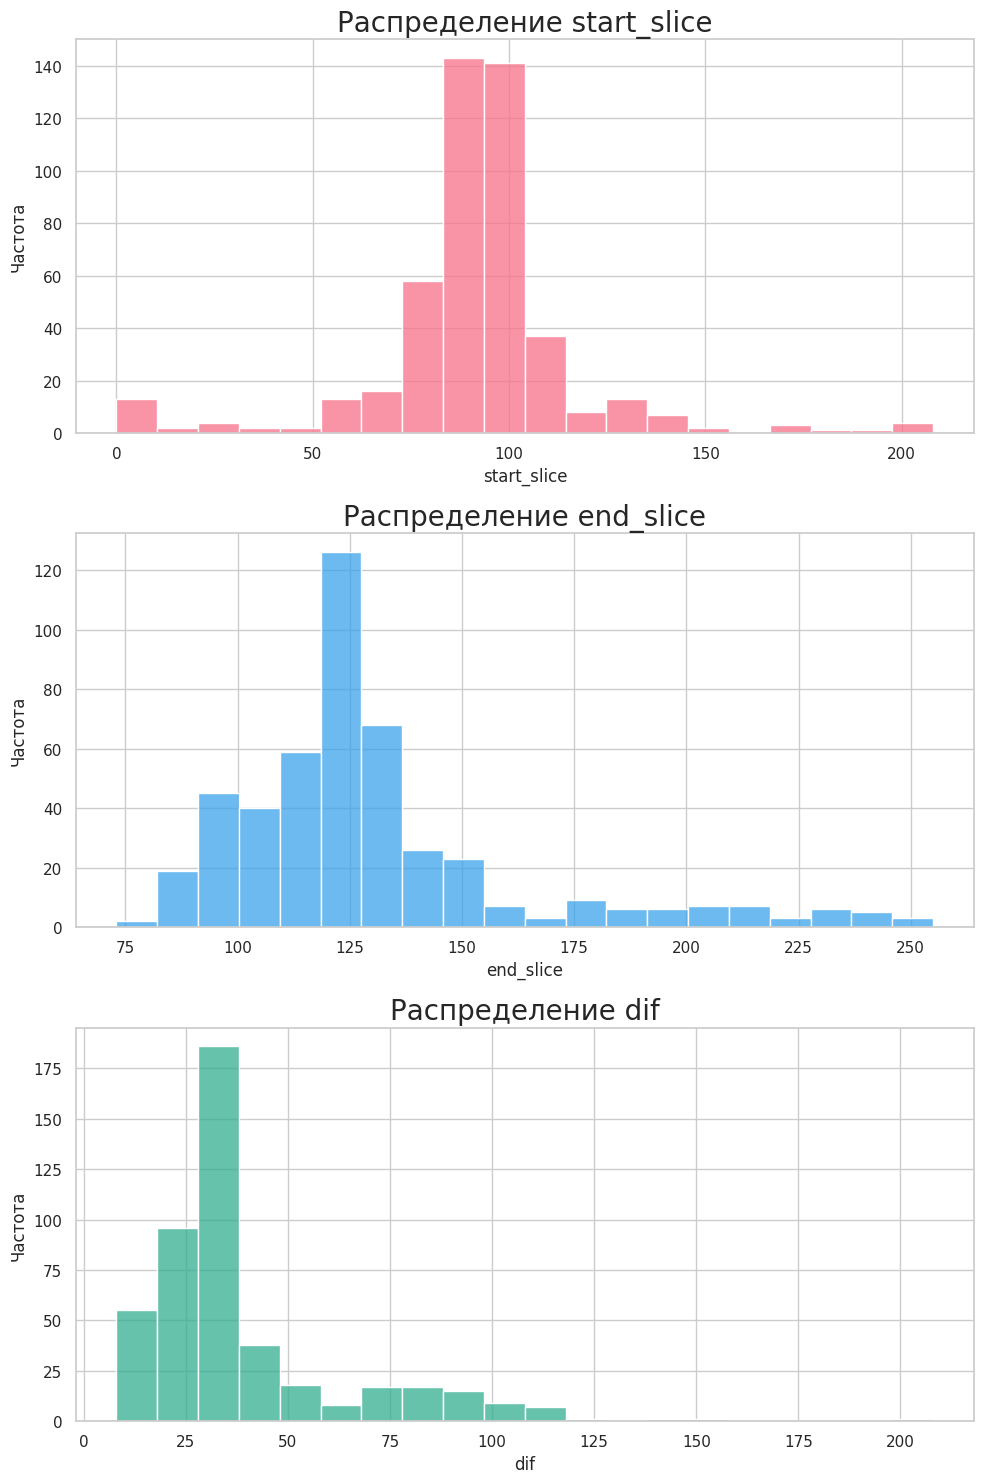

In [ ]:
import seaborn as sns

data = pd.read_csv("cropped_slice_info.csv")
data["dif"] = data["end_slice"] - data["start_slice"]

sns.set(style="whitegrid")
colors = sns.color_palette("husl", 9)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.histplot(data["start_slice"], bins=20, color=colors[0], ax=axes[0])
axes[0].set_title("Распределение start_slice", fontsize=20)
axes[0].set_xlabel("start_slice")
axes[0].set_ylabel("Частота")

sns.histplot(data["end_slice"], bins=20, color=colors[6], ax=axes[1])
axes[1].set_title("Распределение end_slice", fontsize=20)
axes[1].set_xlabel("end_slice")
axes[1].set_ylabel("Частота")

sns.histplot(data["dif"], bins=20, color=colors[4], ax=axes[2])
axes[2].set_title("Распределение dif", fontsize=20)
axes[2].set_xlabel("dif")
axes[2].set_ylabel("Частота")

data["start_ratio"] = data["start_slice"] / data["total_slices"]
data["end_ratio"] = data["end_slice"] / data["total_slices"]
print("Медиана start_ratio:", data["start_ratio"].median())
print("Медиана end_ratio:", data["end_ratio"].median())

plt.tight_layout()
plt.show()

# Exploration of original images of size (512, 512, N)

Медиана start_ratio: 0.37254901960784315
Медиана end_ratio: 0.6836734693877551


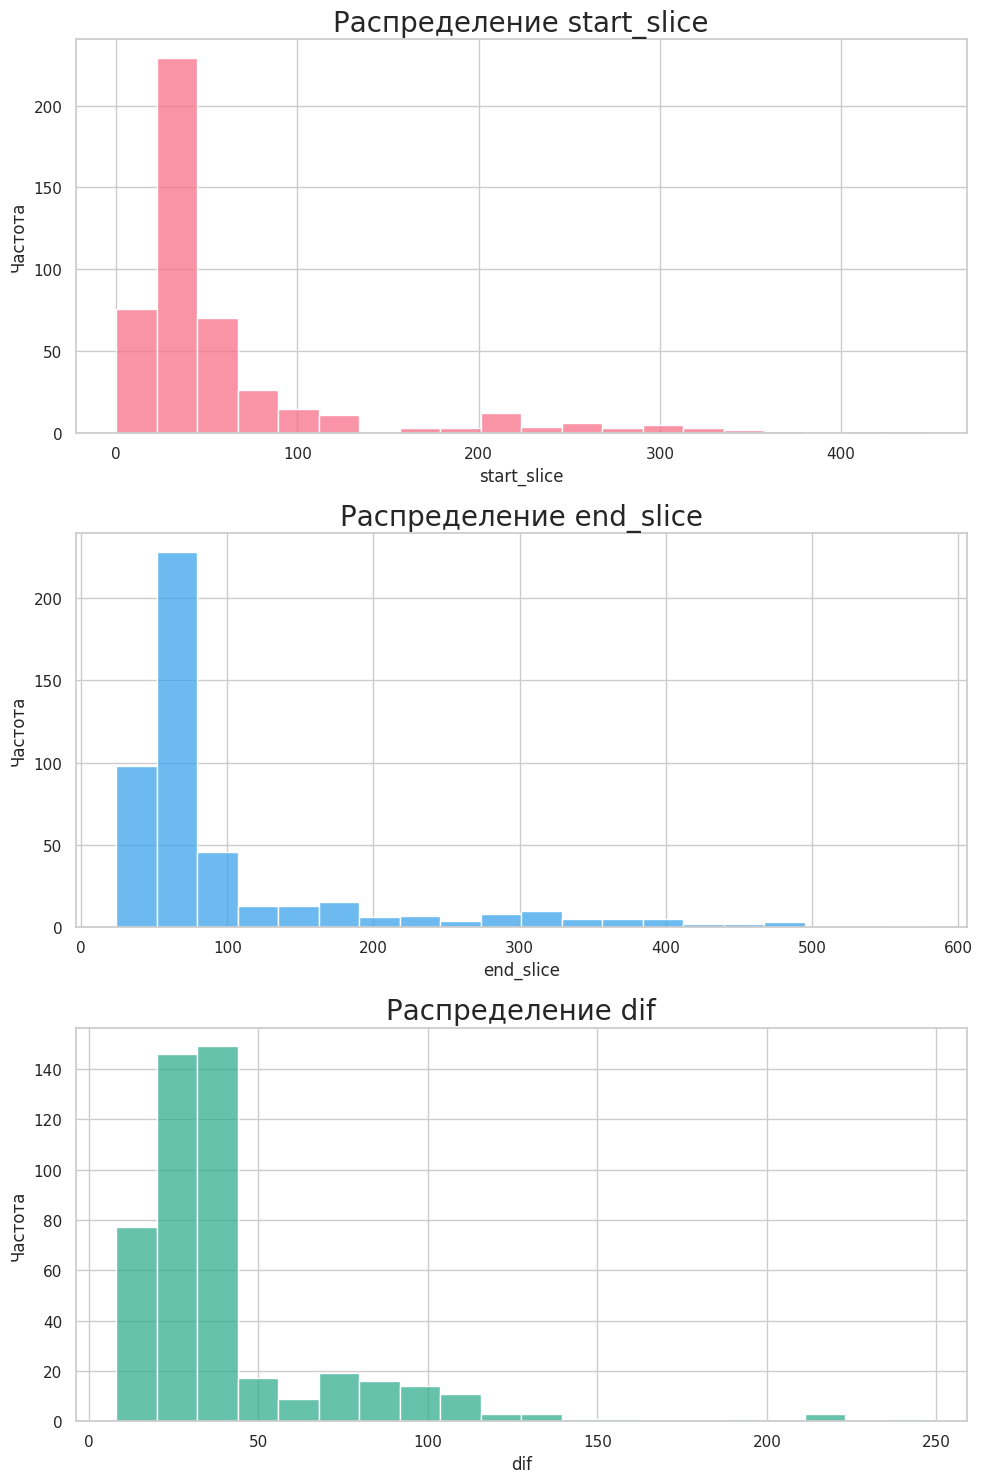

In [ ]:
data = pd.read_csv("slice_info_training_part.csv")
data["dif"] = data["end_slice"] - data["start_slice"]

sns.set(style="whitegrid")
colors = sns.color_palette("husl", 9)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.histplot(data["start_slice"], bins=20, color=colors[0], ax=axes[0])
axes[0].set_title("Распределение start_slice", fontsize=20)
axes[0].set_xlabel("start_slice")
axes[0].set_ylabel("Частота")

sns.histplot(data["end_slice"], bins=20, color=colors[6], ax=axes[1])
axes[1].set_title("Распределение end_slice", fontsize=20)
axes[1].set_xlabel("end_slice")
axes[1].set_ylabel("Частота")

sns.histplot(data["dif"], bins=20, color=colors[4], ax=axes[2])
axes[2].set_title("Распределение dif", fontsize=20)
axes[2].set_xlabel("dif")
axes[2].set_ylabel("Частота")

data["start_ratio"] = data["start_slice"] / data["total_slices"]
data["end_ratio"] = data["end_slice"] / data["total_slices"]
print("Медиана start_ratio:", data["start_ratio"].median())
print("Медиана end_ratio:", data["end_ratio"].median())

plt.tight_layout()
plt.show()

# Data preparation

In [ ]:
!pip -q install torchmetrics
!pip -q install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.9 MB/s eta 0:00:00


In [ ]:
import glob
import json
import numpy as np
import os
import pandas as pd
from patchify import patchify
from PIL import Image
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchmetrics import JaccardIndex, F1Score
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
!rm -r training_data

In [ ]:
os.makedirs("training_data/data3d/train/cts", exist_ok=True)
os.makedirs("training_data/data3d/train/masks", exist_ok=True)
os.makedirs("training_data/data3d/val/cts", exist_ok=True)
os.makedirs("training_data/data3d/val/masks", exist_ok=True)

os.makedirs("training_data/data_patches/train/cts", exist_ok=True)
os.makedirs("training_data/data_patches/train/masks", exist_ok=True)
os.makedirs("training_data/data_patches/val/cts", exist_ok=True)
os.makedirs("training_data/data_patches/val/masks", exist_ok=True)

In [ ]:
def crop_and_pad_image(image, slope_start, intercept_start, slope_end, intercept_end):

    target_depth = 256
    N = image.shape[2]

    # Horizontal and vertical cropping
    cropped_image = image[129:129+target_depth, 168:168+target_depth, :]

    # Calculation of start and end depth indices
    start_pred = slope_start * N + intercept_start
    end_pred = slope_end * N + intercept_end
    start_pred = int(np.round(start_pred))
    end_pred = int(np.round(end_pred))
    # print("start_pred, end_pred", start_pred, end_pred)   ########################

    # Check and adjust values so that the difference is equal to 256
    pancreas_depth_pred = end_pred - start_pred
    # print("pancreas_depth_pred", pancreas_depth_pred)   ########################

    if N >= target_depth:

        if pancreas_depth_pred < target_depth:
            diff = target_depth - pancreas_depth_pred
            half_diff = diff // 2
            start_pred = max(0, start_pred - half_diff)
            end_pred = min(N, end_pred + (diff - half_diff))

            # Rechecking after correction
            pancreas_depth_pred = end_pred - start_pred

            # If still not equal to 256, let's refine it
            if pancreas_depth_pred < target_depth:
                if start_pred == 0:
                    end_pred = target_depth
                if end_pred == N:
                    start_pred = N - target_depth

            # print("start_pred, end_pred", start_pred, end_pred)   ########################

        elif pancreas_depth_pred > target_depth:
            diff = pancreas_depth_pred - target_depth
            start_pred = diff // 2
            end_pred = diff - start_pred

        depth_cropped_image = cropped_image[:, :, start_pred:end_pred]

    else:
        # If there are not enough layers, we add zero padding
        depth_cropped_image = np.zeros((256, 256, target_depth), dtype=image.dtype)
        padding_needed = target_depth - N
        ratio = 1.84    # The pancreas is located approximately in the first third of the images (see data exploration)
        front_padding_idx = int(padding_needed / (1 + ratio)) + 1
        back_padding_idx = target_depth - (padding_needed - front_padding_idx)
        depth_cropped_image[:, :, front_padding_idx:back_padding_idx] = cropped_image[:, :, :]

    return depth_cropped_image

In [ ]:
def create3d(patient_path: str,
             split_group: str,
             regression_line_parameters: tuple[float, float, float, float]
             ) -> tuple[str, str]:

    data = np.load(patient_path)
    image = data["image"]
    mask = data["mask"]

    slope_start, intercept_start, slope_end, intercept_end = regression_line_parameters

    assert image.shape == mask.shape, f"{patient_path} Размерность изображения и маски должна быть одинаковая"

    patient_id = os.path.split(patient_path)[1].split('.')[0]

    # print("image.shape", image.shape)   #########################################
    # Stack 3D slices and convert them into torch tensors
    image_cropped = crop_and_pad_image(image, slope_start, intercept_start, slope_end, intercept_end)
    assert image_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {image_cropped.shape}"

    mask_cropped = crop_and_pad_image(mask, slope_start, intercept_start, slope_end, intercept_end)
    assert mask_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {mask_cropped.shape}"

    image_cropped = np.transpose(image_cropped, axes=(2, 0, 1))  # -> (D x H x W)
    mask_cropped = np.transpose(mask_cropped, axes=(2, 0, 1))  # -> (D x H x W)

    image_cropped = torch.as_tensor(image_cropped)
    image_cropped = image_cropped.type(torch.FloatTensor)
    mask_cropped = torch.as_tensor(mask_cropped)

    image_cropped = image_cropped.numpy()
    ct_path = os.path.join("training_data", "data3d", split_group, "cts", patient_id + "_ct.pt")
    torch.save(image_cropped, ct_path)  # -> (D x H x W)

    mask_cropped = mask_cropped.numpy()
    mask_path = os.path.join("training_data", "data3d", split_group, "masks", patient_id + "_mask.pt")
    torch.save(mask_cropped, mask_path)  # -> (D x H x W)

    return ct_path, mask_path

In [ ]:
random.seed(42)
ids = [i for i in range(1, 590)]
random.shuffle(ids)
split_index = int(0.8 * len(ids))

train_ids = ids[:split_index]
val_ids = ids[split_index:]

dataset_split = {id: "train" for id in train_ids}
dataset_split.update({id: "val" for id in val_ids})

print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Total IDs: {len(dataset_split)}")

Train IDs: 471
Validation IDs: 118
Total IDs: 589


In [ ]:
print(dataset_split)

{491: 'train', 570: 'train', 149: 'train', 154: 'train', 188: 'train', 201: 'train', 231: 'train', 84: 'train', 585: 'train', 412: 'train', 444: 'train', 470: 'train', 60: 'train', 464: 'train', 378: 'train', 384: 'train', 486: 'train', 303: 'train', 417: 'train', 537: 'train', 241: 'train', 532: 'train', 316: 'train', 286: 'train', 304: 'train', 173: 'train', 179: 'train', 266: 'train', 355: 'train', 308: 'train', 427: 'train', 571: 'train', 407: 'train', 13: 'train', 93: 'train', 459: 'train', 101: 'train', 185: 'train', 22: 'train', 119: 'train', 315: 'train', 544: 'train', 514: 'train', 484: 'train', 89: 'train', 428: 'train', 405: 'train', 507: 'train', 478: 'train', 219: 'train', 450: 'train', 320: 'train', 141: 'train', 202: 'train', 401: 'train', 248: 'train', 255: 'train', 538: 'train', 262: 'train', 317: 'train', 381: 'train', 132: 'train', 372: 'train', 76: 'train', 165: 'train', 339: 'train', 156: 'train', 131: 'train', 357: 'train', 180: 'train', 177: 'train', 148: 'train'

In [ ]:
# 25 минут

patients_paths = sorted(glob.glob("drive/MyDrive/npz_files/*"))
patients_count = len(patients_paths)

data = pd.read_csv("slice_info_training_part.csv")
slope_start, intercept_start = np.polyfit(data["total_slices"], data["start_slice"], 1)
slope_end, intercept_end = np.polyfit(data["total_slices"], data["end_slice"], 1)
regression_line_parameters = (slope_start, intercept_start, slope_end, intercept_end)

for i, pth in enumerate(patients_paths):
    if (i + 1) % 50 == 0 or i == 0:
        print("Processing patient {}/{} ...".format(i + 1, patients_count))
    paths3d = create3d(pth, dataset_split[i + 1], regression_line_parameters)

Processing patient 1/588 ...
Processing patient 50/588 ...
Processing patient 100/588 ...
Processing patient 150/588 ...
Processing patient 200/588 ...
Processing patient 250/588 ...
Processing patient 300/588 ...
Processing patient 350/588 ...
Processing patient 400/588 ...
Processing patient 450/588 ...
Processing patient 500/588 ...
Processing patient 550/588 ...


(256, 256, 256) (256, 256, 256)


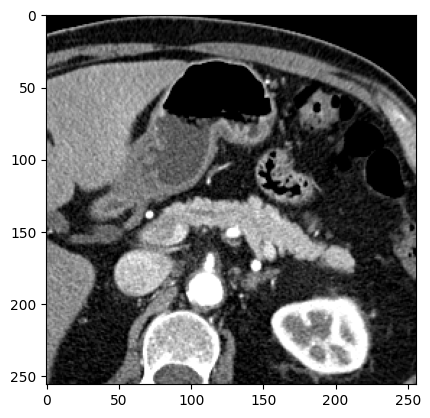

In [ ]:
import matplotlib.pyplot as plt

img = torch.load("training_data/data3d/train/cts/pancreas_0570_ct.pt")
mask = torch.load("training_data/data3d/train/masks/pancreas_0570_mask.pt")
print(img.shape, mask.shape)
plt.imshow(img[120,:,:], cmap="gray")

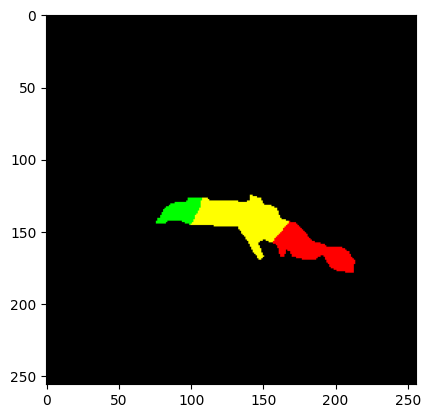

In [ ]:
rgb_images = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
rgb_images[mask == 0] = (0,0,0)
rgb_images[mask == 1] = (0,0,255)
rgb_images[mask == 2] = (0,255,0)
rgb_images[mask == 3] = (255,255,0)
rgb_images[mask == 4] = (255,0,0)
plt.imshow(rgb_images[120,:,:])

In [ ]:
import os
import torch

def check_files(directory, expected_shape_cts, expected_shape_masks):
    """
    Checking files in a given directory for compliance with expected sizes.

    :param directory: Directory with training data
    :param expected_shape_cts: Expected size for cts files
    :param expected_shape_masks: Expected size for masks files
    """
    subdirs = ["train", "val"]
    data_types = ["cts", "masks"]

    for subdir in subdirs:
        for data_type in data_types:
            path = os.path.join(directory, subdir, data_type)
            expected_shape = expected_shape_cts if data_type == "cts" else expected_shape_masks

            for root, _, files in os.walk(path):
                for file in files:
                    if file.endswith(".pt"):
                        file_path = os.path.join(root, file)
                        try:
                            data = torch.load(file_path)
                            data_shape = data.shape

                            if data_shape != expected_shape:
                                print(f"Файл {file_path} имеет размер {data_shape}, но ожидается {expected_shape}")
                        except Exception as e:
                            print(f"Ошибка при загрузке файла {file_path}: {e}")

directory = "training_data/data3d"
expected_shape_cts = (256, 256, 256)
expected_shape_masks = (256, 256, 256)

check_files(directory, expected_shape_cts, expected_shape_masks)

In [ ]:
def create_patch(image: np.ndarray) -> np.ndarray:
    # input shape = (256, 256, 256)
    patch = patchify(
        image, patch_size=(64, 64, 64), step=64
    )   # -> output shape = (4, 4, 4, 64, 64, 64)
    patch = np.reshape(patch,
                       (-1, patch.shape[3], patch.shape[4], patch.shape[5])
                       )    # -> output shape = (64, 64, 64, 64)
    return patch

def save_patches(patient_name: str, patient_group: str) -> None:
    ct3d_path = f"training_data/data3d/{patient_group}/cts/{patient_name}_ct.pt"
    mask3d_path = f"training_data/data3d/{patient_group}/masks/{patient_name}_mask.pt"

    # Save image as patches
    ct3d = torch.load(ct3d_path)
    ct_patches = create_patch(ct3d)
    for patch_id, patch in enumerate(ct_patches):
        patch_path = os.path.join(
            "training_data", "data_patches", patient_group, "cts",
            "{}_ct_{:02d}.pt".format(patient_name, patch_id)
        )
        # torch.save(torch.from_numpy(patch), patch_path)     # -> output shape = (64, 64, 64)
        torch.save(patch, patch_path)     # -> output shape = (64, 64, 64)

    # Save mask as patches
    mask3d = torch.load(mask3d_path)
    mask_patches = create_patch(mask3d)
    for patch_id, patch in enumerate(mask_patches):
        # encoded_patch = one_hot_encode_rgb(torch.from_numpy(patch))
        patch_path = os.path.join(
            "training_data", "data_patches", patient_group, "masks",
            "{}_mask_{:02d}.pt".format(patient_name, patch_id)
        )
        # torch.save(torch.from_numpy(patch), patch_path)     # -> output shape = (64, 64, 64)
        torch.save(patch, patch_path)     # -> output shape = (64, 64, 64)

In [ ]:
!rm -r training_data/data_patches

In [ ]:
# 13 минут

# Create the dataset
patient_ids = [i for i in range(1, 590)]
patient_ids.remove(342)
patient_list = [f"pancreas_{i:04d}" for i in patient_ids]

for i, pat_name in enumerate(patient_list):
    if (i + 1) % 50 == 0:
        print("Processing patient {}/{} ...".format(i + 1, patients_count))
    save_patches(pat_name, dataset_split[i+1])

Processing patient 50/588 ...
Processing patient 100/588 ...
Processing patient 150/588 ...
Processing patient 200/588 ...
Processing patient 250/588 ...
Processing patient 300/588 ...
Processing patient 350/588 ...
Processing patient 400/588 ...
Processing patient 450/588 ...
Processing patient 500/588 ...
Processing patient 550/588 ...


In [ ]:
print(len(os.listdir("training_data/data_patches/train/cts")), len(os.listdir("training_data/data_patches/train/cts")) / (4*4*4))
print(len(os.listdir("training_data/data_patches/train/masks")), len(os.listdir("training_data/data_patches/train/masks")) / (4*4*4))
print(len(os.listdir("training_data/data_patches/val/cts")), len(os.listdir("training_data/data_patches/val/cts")) / (4*4*4))
print(len(os.listdir("training_data/data_patches/val/masks")), len(os.listdir("training_data/data_patches/val/masks")) / (4*4*4))

30080 470.0
30080 470.0
7552 118.0
7552 118.0


In [ ]:
print(torch.load("training_data/data_patches/train/cts/pancreas_0015_ct_54.pt").shape)
print(torch.load("training_data/data_patches/train/masks/pancreas_0015_mask_54.pt").shape)
print(torch.load("training_data/data_patches/val/cts/pancreas_0007_ct_00.pt").shape)
print(torch.load("training_data/data_patches/val/masks/pancreas_0007_mask_00.pt").shape)

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


# Training

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, features=16, dropout_rate=0.3):
        super().__init__()

        # Encoder
        self.encoder1 = UNet3D.conv_block(in_channels, features)
        self.encoder2 = UNet3D.conv_block(features, features * 2)
        self.encoder3 = UNet3D.conv_block(features * 2, features * 4)
        self.encoder4 = UNet3D.conv_block(features * 4, features * 8)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet3D.conv_block(features * 8, features * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(features * 16, features * 16, kernel_size=2, stride=2)
        self.decoder4 = UNet3D.conv_block(features * 24, features * 8)
        self.upconv3 = nn.ConvTranspose3d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder3 = UNet3D.conv_block(features * 12, features * 4)
        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 4, kernel_size=2, stride=2)
        self.decoder2 = UNet3D.conv_block(features * 6, features * 2)
        self.upconv1 = nn.ConvTranspose3d(features * 2, features * 2, kernel_size=2, stride=2)
        self.decoder1 = UNet3D.conv_block(features * 3, features)

        # Output layer
        self.last_conv = nn.Conv3d(in_channels=features, out_channels=out_channels, kernel_size=1)
        # self.last_upconv1 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)
        # self.last_upconv2 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)   #################

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):

        # Encoding path
        enc1_copy = self.encoder1(x)
        enc1 = self.dropout(self.pool(enc1_copy))
        enc2_copy = self.encoder2(enc1)
        enc2 = self.dropout(self.pool(enc2_copy))
        enc3_copy = self.encoder3(enc2)
        enc3 = self.dropout(self.pool(enc3_copy))
        enc4_copy = self.encoder4(enc3)
        enc4 = self.dropout(self.pool(enc4_copy))

        # Bottleneck
        bn = self.bottleneck(enc4)
        # bn = self.bottleneck(enc3)

        # Decoding path
        dec4 = self.dropout(self.upconv4(bn))
        dec4 = self.decoder4(torch.cat((dec4, enc4_copy), dim=1))
        dec3 = self.dropout(self.upconv3(dec4))
        dec3 = self.decoder3(torch.cat((dec3, enc3_copy), dim=1))
        dec2 = self.dropout(self.upconv2(dec3))
        dec2 = self.decoder2(torch.cat((dec2, enc2_copy), dim=1))
        dec1 = self.dropout(self.upconv1(dec2))
        dec1 = self.decoder1(torch.cat((dec1, enc1_copy), dim=1))
        output = self.last_conv(dec1)
        # output = self.last_upconv1(output)
        # output = self.last_upconv2(output)    ###########################

        return output

    @staticmethod
    def conv_block(in_features, out_features):
        return nn.Sequential(
            nn.Conv3d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU(),
            nn.Conv3d(
                in_channels=out_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU()
        )

In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D().to(device)
summary(model, (1, 64, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 64, 64, 64]             448
       BatchNorm3d-2       [-1, 16, 64, 64, 64]              32
              ReLU-3       [-1, 16, 64, 64, 64]               0
            Conv3d-4       [-1, 16, 64, 64, 64]           6,928
       BatchNorm3d-5       [-1, 16, 64, 64, 64]              32
              ReLU-6       [-1, 16, 64, 64, 64]               0
         MaxPool3d-7       [-1, 16, 32, 32, 32]               0
           Dropout-8       [-1, 16, 32, 32, 32]               0
            Conv3d-9       [-1, 32, 32, 32, 32]          13,856
      BatchNorm3d-10       [-1, 32, 32, 32, 32]              64
             ReLU-11       [-1, 32, 32, 32, 32]               0
           Conv3d-12       [-1, 32, 32, 32, 32]          27,680
      BatchNorm3d-13       [-1, 32, 32, 32, 32]              64
             ReLU-14       [-1, 32, 32,

In [ ]:
class PartSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=False):
        self.root_dir = root_dir
        self.cts = sorted(os.listdir(os.path.join(self.root_dir, "cts")))
        self.masks = sorted(os.listdir(os.path.join(self.root_dir, "masks")))
        self.transform = transform
        assert len(self.cts) == len(self.masks), "Количество изображений и масок должно совпадать"

    def __len__(self):
        return len(self.cts)

    def __getitem__(self, idx):
        # load tensors
        image_path = os.path.join(self.root_dir, "cts", self.cts[idx])
        mask_path = os.path.join(self.root_dir, "masks", self.masks[idx])
        # add channel dimension
        image = torch.load(image_path)
        image = torch.from_numpy(image).unsqueeze(0)     # -> shape = (C, D, H, W)
        mask = torch.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)   # -> shape = (C, D, H, W)

        # scale ct images
        image = image / 255.0

        # restore data type after transformation
        image = image.type(torch.FloatTensor)
        mask = mask.type(torch.IntTensor)

        return image, mask

## Part 1 (first 34 epochs)

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device, scheduler):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)
    losses = {"train": [], "val": []}
    metrics = {"IoU": {"train": [], "val": []},
               "F1score": {"train": [], "val": []}}
    show_every = 100
    for epoch in tqdm(range(1, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Step the scheduler after each batch
            scheduler.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"PatchUNet{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "PatchUNetcp.pt")

    return model

In [ ]:
!rm -r training_data/data_patches/train/cts/.ipynb_checkpoints
!rm -r training_data/data_patches/train/masks/.ipynb_checkpoints

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
# first 34 epochs

batch_size = 32
root_dir = os.path.join("training_data", "data_patches")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and the training parameters
model = UNet3D().to(device)
n_epochs = 200
# try reduction="sum" if gradients are too small
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
learning_rate = 1e-1  # 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
iterations_per_epoch = len(train_dataloader)
# The learning rate will increase over 5 epochs, then there will be a similar decreasing cycle
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-1,
                                              step_size_up=iterations_per_epoch * 5,
                                              mode="triangular2")

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device, scheduler
)

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 940 ...
Batch IDX 0: Training Loss: 0.0014 	Train IoU: [0.7429965138435364, 0.0005899980315007269, 2.7047567527915817e-06, 0.0, 0.0] 	Train F1: [0.8525508046150208, 0.0011793003650382161, 5.409498953667935e-06, 0.0, 0.0]
101 / 940 ...
Batch IDX 100: Training Loss: 0.0810 	Train IoU: [0.9991555213928223, 0.0, 0.0, 0.0, 0.0] 	Train F1: [0.9995775818824768, 0.0, 0.0, 0.0, 0.0]
201 / 940 ...
Batch IDX 200: Training Loss: 0.0927 	Train IoU: [0.9992383718490601, 0.0, 0.0, 0.0, 0.0] 	Train F1: [0.9996190667152405, 0.0, 0.0, 0.0, 0.0]
301 / 940 ...
Batch IDX 300: Training Loss: 0.0963 	Train IoU: [0.9856312274932861, 0.0, 0.0, 0.0, 0.0] 	Train F1: [0.9927636384963989, 0.0, 0.0, 0.0, 0.0]
401 / 940 ...
Batch IDX 400: Training Loss: 0.0993 	Train IoU: [0.990860104560852, 0.0, 0.0, 0.0, 0.0] 	Train F1: [0.9954090714454651, 0.0, 0.0, 0.0, 0.0]
501 / 940 ...
Batch IDX 500: Training Loss: 0.1020 	Train IoU: [0.9945656061172485, 0.0, 0.0, 0.0, 0.0] 	Train F1: [0.

  0%|          | 1/201 [21:41<72:18:19, 1301.50s/it]

Epoch: 1 	Training Loss: 0.1135 	Validation Loss: 0.0243 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #2 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  1%|          | 2/201 [43:27<72:04:48, 1303.96s/it]

Epoch: 2 	Training Loss: 0.0244 	Validation Loss: 0.0243 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #3 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  1%|▏         | 3/201 [1:04:55<71:18:52, 1296.63s/it]

Epoch: 3 	Training Loss: 0.0240 	Validation Loss: 0.0237 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #4 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  2%|▏         | 4/201 [1:26:04<70:22:20, 1285.99s/it]

Epoch: 4 	Training Loss: 0.0237 	Validation Loss: 0.0245 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #5 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  2%|▏         | 5/201 [1:46:53<69:16:38, 1272.44s/it]

Epoch: 5 	Training Loss: 0.0234 	Validation Loss: 0.0234 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #6 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  3%|▎         | 6/201 [2:07:28<68:14:54, 1259.97s/it]

Epoch: 6 	Training Loss: 0.0240 	Validation Loss: 0.0266 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #7 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  3%|▎         | 7/201 [2:27:56<67:20:09, 1249.53s/it]

Epoch: 7 	Training Loss: 0.0224 	Validation Loss: 0.0222 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #8 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  4%|▍         | 8/201 [2:48:18<66:30:19, 1240.52s/it]

Epoch: 8 	Training Loss: 0.0213 	Validation Loss: 0.0198 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #9 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  4%|▍         | 9/201 [3:08:41<65:52:11, 1235.06s/it]

Epoch: 9 	Training Loss: 0.0199 	Validation Loss: 0.0196 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #10 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  5%|▍         | 10/201 [3:29:10<65:25:41, 1233.20s/it]

Epoch: 10 	Training Loss: 0.0185 	Validation Loss: 0.0184 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #11 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  5%|▌         | 11/201 [3:49:35<64:57:50, 1230.90s/it]

Epoch: 11 	Training Loss: 0.0180 	Validation Loss: 0.0184 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #12 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  6%|▌         | 12/201 [4:10:02<64:33:05, 1229.55s/it]

Epoch: 12 	Training Loss: 0.0181 	Validation Loss: 0.0183 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #13 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  6%|▋         | 13/201 [4:30:28<64:09:16, 1228.49s/it]

Epoch: 13 	Training Loss: 0.0181 	Validation Loss: 0.0205 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #14 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  7%|▋         | 14/201 [4:50:55<63:47:22, 1228.03s/it]

Epoch: 14 	Training Loss: 0.0180 	Validation Loss: 0.0177 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #15 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  7%|▋         | 15/201 [5:11:21<63:24:45, 1227.34s/it]

Epoch: 15 	Training Loss: 0.0181 	Validation Loss: 0.0232 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #16 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  8%|▊         | 16/201 [5:31:48<63:04:16, 1227.33s/it]

Epoch: 16 	Training Loss: 0.0176 	Validation Loss: 0.0167 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #17 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  8%|▊         | 17/201 [5:52:15<62:43:52, 1227.35s/it]

Epoch: 17 	Training Loss: 0.0162 	Validation Loss: 0.0167 	Validation F1 Score: [0.9980701857199104, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961631262706498, 0.0, 0.0, 0.0, 0.0]
=== Epoch #18 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  9%|▉         | 18/201 [6:12:44<62:24:48, 1227.80s/it]

Epoch: 18 	Training Loss: 0.0152 	Validation Loss: 0.0163 	Validation F1 Score: [0.9982608342069691, 0.15420349897514393, 0.0, 0.0, 0.0] 	Validation IoU: [0.9965419130305112, 0.1037523523341483, 0.0, 0.0, 0.0]
=== Epoch #19 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  9%|▉         | 19/201 [6:33:13<62:04:44, 1227.94s/it]

Epoch: 19 	Training Loss: 0.0143 	Validation Loss: 0.0151 	Validation F1 Score: [0.9982679193302736, 0.14553861198223553, 0.0, 0.0, 0.0] 	Validation IoU: [0.9965555713338367, 0.0930588072753103, 0.0, 0.0, 0.0]
=== Epoch #20 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 10%|▉         | 20/201 [6:53:42<61:45:22, 1228.30s/it]

Epoch: 20 	Training Loss: 0.0135 	Validation Loss: 0.0149 	Validation F1 Score: [0.998382526434074, 0.18541506837406768, 0.0, 0.0, 0.0] 	Validation IoU: [0.9967837101322109, 0.12383989766780268, 0.0, 0.0, 0.0]
=== Epoch #21 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 10%|█         | 21/201 [7:14:13<61:27:42, 1229.24s/it]

Epoch: 21 	Training Loss: 0.0132 	Validation Loss: 0.0155 	Validation F1 Score: [0.9983715288719889, 0.17461974370679068, 0.0, 0.0, 0.0] 	Validation IoU: [0.9967615475593987, 0.11606534226308922, 0.0, 0.0, 0.0]
=== Epoch #22 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 11%|█         | 22/201 [7:34:43<61:07:34, 1229.36s/it]

Epoch: 22 	Training Loss: 0.0133 	Validation Loss: 0.0150 	Validation F1 Score: [0.9983572477506379, 0.1651737846266276, 0.0, 0.020149954032326528, 0.0] 	Validation IoU: [0.9967337695218749, 0.10956462348999825, 0.0, 0.01070322949355182, 0.0]
=== Epoch #23 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 11%|█▏        | 23/201 [7:55:15<60:49:35, 1230.20s/it]

Epoch: 23 	Training Loss: 0.0133 	Validation Loss: 0.0150 	Validation F1 Score: [0.9983827944024134, 0.15718597972590942, 0.0, 0.035151847436127814, 0.0] 	Validation IoU: [0.9967846423387527, 0.10345072752558843, 0.0, 0.01953563466480064, 0.0]
=== Epoch #24 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 12%|█▏        | 24/201 [8:15:46<60:29:33, 1230.36s/it]

Epoch: 24 	Training Loss: 0.0134 	Validation Loss: 0.0162 	Validation F1 Score: [0.9983242383952868, 0.2199520858209896, 0.0, 0.1000626970706404, 0.0] 	Validation IoU: [0.9966714700399819, 0.14623841543295185, 0.0, 0.05929936400086987, 0.0]
=== Epoch #25 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 12%|█▏        | 25/201 [8:36:17<60:10:14, 1230.77s/it]

Epoch: 25 	Training Loss: 0.0133 	Validation Loss: 0.0147 	Validation F1 Score: [0.9984981990971807, 0.20096503308544061, 0.0, 0.05778181676553578, 0.0012975395670995783] 	Validation IoU: [0.9970136077727302, 0.13357844968746668, 0.0, 0.033195468784839956, 0.0006588350598900371]
=== Epoch #26 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 13%|█▎        | 26/201 [8:56:46<59:47:50, 1230.11s/it]

Epoch: 26 	Training Loss: 0.0127 	Validation Loss: 0.0142 	Validation F1 Score: [0.998477163456254, 0.21672324702154522, 0.0, 0.11458114666101657, 0.00027737237653158354] 	Validation IoU: [0.9969727545976639, 0.14787245634258814, 0.0, 0.07144281794430522, 0.00013997627758140818]
=== Epoch #27 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 13%|█▎        | 27/201 [9:17:16<59:27:23, 1230.14s/it]

Epoch: 27 	Training Loss: 0.0123 	Validation Loss: 0.0138 	Validation F1 Score: [0.9985160433639915, 0.16931129514323093, 0.0, 0.1381501761562134, 0.0] 	Validation IoU: [0.9970493932901803, 0.10913586930196212, 0.0, 0.08684772843488937, 0.0]
=== Epoch #28 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 14%|█▍        | 28/201 [9:37:49<59:09:22, 1231.00s/it]

Epoch: 28 	Training Loss: 0.0116 	Validation Loss: 0.0138 	Validation F1 Score: [0.9985419138003204, 0.20606962418821503, 0.0, 0.16298298589609364, 0.0] 	Validation IoU: [0.9971010245509067, 0.1401688855067285, 0.0, 0.10609600148358891, 0.0]
=== Epoch #29 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 14%|█▍        | 29/201 [9:58:24<58:52:12, 1232.17s/it]

Epoch: 29 	Training Loss: 0.0109 	Validation Loss: 0.0130 	Validation F1 Score: [0.9986027057393122, 0.23251380152405698, 0.0, 0.1978465590144555, 0.02272021952437896] 	Validation IoU: [0.9972219070640661, 0.16186332085077484, 0.0, 0.13259829631626138, 0.012318909132942682]
=== Epoch #30 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 15%|█▍        | 30/201 [10:18:56<58:31:43, 1232.18s/it]

Epoch: 30 	Training Loss: 0.0102 	Validation Loss: 0.0130 	Validation F1 Score: [0.9986078468924862, 0.26963633829032235, 0.0, 0.21580495817288156, 0.009290692268176965] 	Validation IoU: [0.9972319448903456, 0.19568241267897665, 0.0, 0.14726434041548894, 0.004815882781967649]
=== Epoch #31 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 15%|█▌        | 31/201 [10:39:30<58:12:47, 1232.75s/it]

Epoch: 31 	Training Loss: 0.0098 	Validation Loss: 0.0130 	Validation F1 Score: [0.9986280652426057, 0.2598177031132162, 0.0, 0.2184201835738411, 0.0022198929202543586] 	Validation IoU: [0.9972717251818058, 0.18834269909583304, 0.0, 0.1483168373946436, 0.0011315112476148574]
=== Epoch #32 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 16%|█▌        | 32/201 [11:00:04<57:53:07, 1233.06s/it]

Epoch: 32 	Training Loss: 0.0098 	Validation Loss: 0.0127 	Validation F1 Score: [0.9986352321960158, 0.2991497860590028, 0.0, 0.21940065515334906, 0.05353708103409144] 	Validation IoU: [0.9972858082945064, 0.21911520708620674, 0.0, 0.1503088156026995, 0.030007425455304486]
=== Epoch #33 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 16%|█▋        | 33/201 [11:20:39<57:33:50, 1233.52s/it]

Epoch: 33 	Training Loss: 0.0095 	Validation Loss: 0.0126 	Validation F1 Score: [0.9985879778356875, 0.2929724215148056, 0.03318141835472365, 0.2140127646535047, 0.017478208962822494] 	Validation IoU: [0.9971918617769823, 0.21519507024480597, 0.018290551684173297, 0.14699960842193893, 0.009165707022413884]
=== Epoch #34 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 17%|█▋        | 34/201 [11:41:11<57:12:05, 1233.09s/it]

Epoch: 34 	Training Loss: 0.0094 	Validation Loss: 0.0123 	Validation F1 Score: [0.998599116832523, 0.2669075406787885, 0.058604384418300716, 0.21396332453424924, 0.04745774469940166] 	Validation IoU: [0.9972139559054779, 0.19384011793960582, 0.03420839511232709, 0.14812299781089555, 0.026247552650787282]
=== Epoch #35 ===
=== Training ===
1 / 940 ...


 17%|█▋        | 34/201 [11:41:38<57:26:18, 1238.19s/it]


KeyboardInterrupt: 

## Part 2

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device, scheduler):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)

    # losses = {"train": [], "val": []}
    # metrics = {"IoU": {"train": [], "val": []},
    #            "F1score": {"train": [], "val": []}}
    with open("history.json") as f:
        d = json.load(f)
        losses = d["losses"]
        metrics = d["metrics"]

    show_every = 100
    for epoch in tqdm(range(31, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Step the scheduler after each batch
            scheduler.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"PatchUNet{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "PatchUNetcp.pt")

    return model

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
# последние ?? эпох

batch_size = 32
root_dir = os.path.join("training_data", "data_patches")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and the training parameters
model = UNet3D().to(device)
model.load_state_dict(torch.load("PatchUNet30epochsCP.pt"))

n_epochs = 200
# try reduction="sum" if gradients are too small
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
learning_rate = 1e-2  # 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iterations_per_epoch = len(train_dataloader)
# The learning rate will increase over 5 epochs, then there will be a similar decreasing cycle
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2,
                                              step_size_up=iterations_per_epoch * 5,
                                              mode="triangular2")

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device, scheduler
)

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #31 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  0%|          | 1/201 [20:08<67:08:39, 1208.60s/it]

Epoch: 31 	Training Loss: 0.0098 	Validation Loss: 0.0129 	Validation F1 Score: [0.9986234352750293, 0.2781387063539222, 0.0, 0.22012647741699395, 0.006326999513676436] 	Validation IoU: [0.9972628728818085, 0.20183706666321702, 0.0, 0.15075379458415736, 0.0032692321721573903]
=== Epoch #32 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  1%|          | 2/201 [39:59<66:14:04, 1198.21s/it]

Epoch: 32 	Training Loss: 0.0097 	Validation Loss: 0.0130 	Validation F1 Score: [0.9986277927281493, 0.25173824841612397, 0.0, 0.2225790560881297, 0.022020631369279293] 	Validation IoU: [0.9972709740622568, 0.18169556612248647, 0.0, 0.15336940742376315, 0.011643058564343738]
=== Epoch #33 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  1%|▏         | 3/201 [59:35<65:21:15, 1188.26s/it]

Epoch: 33 	Training Loss: 0.0096 	Validation Loss: 0.0123 	Validation F1 Score: [0.9985878086191112, 0.2921419607066004, 3.265407971319569e-05, 0.22158581401087712, 0.026500601436640927] 	Validation IoU: [0.9971915301630052, 0.21457489732042864, 1.6339720956639827e-05, 0.15297474247468712, 0.014206580994295556]
=== Epoch #34 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  2%|▏         | 4/201 [1:18:49<64:16:55, 1174.70s/it]

Epoch: 34 	Training Loss: 0.0094 	Validation Loss: 0.0125 	Validation F1 Score: [0.998627586132389, 0.2535295074265963, 0.009269382441512573, 0.21018203043868044, 0.0863754748482171] 	Validation IoU: [0.997270862429829, 0.18410104055177634, 0.004835191274743643, 0.14380669387381173, 0.05021456785062444]
=== Epoch #35 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  2%|▏         | 5/201 [1:37:44<63:09:56, 1160.18s/it]

Epoch: 35 	Training Loss: 0.0092 	Validation Loss: 0.0120 	Validation F1 Score: [0.998637005939322, 0.29165903515955904, 0.06682311443555745, 0.20919855903162374, 0.16229365184514435] 	Validation IoU: [0.9972901786282912, 0.21549090075945893, 0.03955310312264019, 0.14375896781935593, 0.10487837870200796]
=== Epoch #36 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  3%|▎         | 6/201 [1:56:25<62:07:35, 1146.95s/it]

Epoch: 36 	Training Loss: 0.0088 	Validation Loss: 0.0122 	Validation F1 Score: [0.9986419159982164, 0.2968278855272328, 0.13843294522469524, 0.21412761617127324, 0.1451096523025811] 	Validation IoU: [0.9972990806830131, 0.22087985275714545, 0.09020437266168548, 0.14856584261083222, 0.09279165559429063]
=== Epoch #37 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  3%|▎         | 7/201 [2:14:57<61:11:22, 1135.48s/it]

Epoch: 37 	Training Loss: 0.0084 	Validation Loss: 0.0116 	Validation F1 Score: [0.9986709141630238, 0.322313208836407, 0.14290534502578014, 0.23505556189816085, 0.18722715473687473] 	Validation IoU: [0.9973569572982142, 0.2417889678366364, 0.09163488855539087, 0.1659632113379164, 0.12726121578021252]
=== Epoch #38 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  4%|▍         | 8/201 [2:33:20<60:19:09, 1125.13s/it]

Epoch: 38 	Training Loss: 0.0081 	Validation Loss: 0.0116 	Validation F1 Score: [0.9986939607030254, 0.30926535884214373, 0.1394432427803591, 0.2380213619220185, 0.18645376024000204] 	Validation IoU: [0.9974025338888168, 0.23124280285684123, 0.09133184454956297, 0.1700287620629844, 0.12535454769527798]
=== Epoch #39 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  4%|▍         | 9/201 [2:51:50<59:45:27, 1120.46s/it]

Epoch: 39 	Training Loss: 0.0078 	Validation Loss: 0.0112 	Validation F1 Score: [0.9986817132113344, 0.3249258517378436, 0.13771180137972175, 0.21739438351172702, 0.21442663535955203] 	Validation IoU: [0.9973781765517542, 0.24369325094078903, 0.0904679155945028, 0.15344652238743917, 0.14981317999072263]
=== Epoch #40 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  5%|▍         | 10/201 [3:10:29<59:25:03, 1119.91s/it]

Epoch: 40 	Training Loss: 0.0076 	Validation Loss: 0.0114 	Validation F1 Score: [0.998707092414468, 0.32233055618885603, 0.15081469052554092, 0.2504350173414916, 0.19397563220571995] 	Validation IoU: [0.9974286970445665, 0.24189699092805653, 0.09953046086272896, 0.18035901360403608, 0.13362082023574612]
=== Epoch #41 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  5%|▌         | 11/201 [3:28:58<58:56:15, 1116.71s/it]

Epoch: 41 	Training Loss: 0.0075 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987078420186447, 0.3229465803320883, 0.15200302009549688, 0.24369116294949011, 0.2060533409195945] 	Validation IoU: [0.9974300558284178, 0.2427308843732551, 0.10053755432787603, 0.17438338941126674, 0.14395353874681596]
=== Epoch #42 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  6%|▌         | 12/201 [3:47:24<58:27:34, 1113.51s/it]

Epoch: 42 	Training Loss: 0.0074 	Validation Loss: 0.0116 	Validation F1 Score: [0.9987047385361235, 0.32634089696536756, 0.1555298761192362, 0.2552260181146883, 0.20369184059801243] 	Validation IoU: [0.9974241059715465, 0.2460961181474223, 0.10291351858719835, 0.18407133709004453, 0.14101289876665668]
=== Epoch #43 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  6%|▋         | 13/201 [4:05:46<57:58:00, 1110.00s/it]

Epoch: 43 	Training Loss: 0.0074 	Validation Loss: 0.0116 	Validation F1 Score: [0.9987117776931342, 0.31493389154478546, 0.14791674748501124, 0.2583322843206973, 0.17801956131345725] 	Validation IoU: [0.9974378354973712, 0.23562690906815617, 0.09715322906080381, 0.18642284137881765, 0.12069120758444453]
=== Epoch #44 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  7%|▋         | 14/201 [4:24:12<57:35:09, 1108.61s/it]

Epoch: 44 	Training Loss: 0.0074 	Validation Loss: 0.0115 	Validation F1 Score: [0.9987016605623698, 0.30950909150789996, 0.1530740327681257, 0.24430084898557328, 0.20140336818773086] 	Validation IoU: [0.9974176643763558, 0.2299164977709968, 0.10155174601860088, 0.17504891044296467, 0.14078042680354222]
=== Epoch #45 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  7%|▋         | 15/201 [4:42:35<57:11:27, 1106.92s/it]

Epoch: 45 	Training Loss: 0.0075 	Validation Loss: 0.0116 	Validation F1 Score: [0.998702692783485, 0.31429518743095547, 0.1433932485790939, 0.2580524946764299, 0.18792897999366565] 	Validation IoU: [0.9974200142137075, 0.23671722828889175, 0.09415066396320333, 0.1874968281518874, 0.13103770653217028]
=== Epoch #46 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  8%|▊         | 16/201 [5:01:07<56:57:35, 1108.41s/it]

Epoch: 46 	Training Loss: 0.0074 	Validation Loss: 0.0111 	Validation F1 Score: [0.9986816874500049, 0.3461906502370612, 0.17125353437944085, 0.26681642153007334, 0.19754501042959835] 	Validation IoU: [0.9973785293809438, 0.26148464755249856, 0.11546457653507093, 0.19565391027005055, 0.13774600655227204]
=== Epoch #47 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  8%|▊         | 17/201 [5:19:39<56:42:54, 1109.65s/it]

Epoch: 47 	Training Loss: 0.0071 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987221675909171, 0.326559918118696, 0.1426674626660099, 0.2574374843868824, 0.23900089424963789] 	Validation IoU: [0.9974587514238843, 0.2453042122212799, 0.09421581614545993, 0.1875431741226887, 0.171003089874383]
=== Epoch #48 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  9%|▉         | 18/201 [5:38:00<56:16:47, 1107.15s/it]

Epoch: 48 	Training Loss: 0.0070 	Validation Loss: 0.0111 	Validation F1 Score: [0.9987059930118464, 0.34340623709924667, 0.1694914998064386, 0.27325759833516805, 0.19521935878546468] 	Validation IoU: [0.9974267045825215, 0.259559309877474, 0.11366830434565338, 0.20103241857368168, 0.13610025245293786]
=== Epoch #49 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


  9%|▉         | 19/201 [5:56:23<55:54:17, 1105.81s/it]

Epoch: 49 	Training Loss: 0.0069 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987374725988356, 0.3350782837576659, 0.16660200321521035, 0.2704185665426263, 0.22262821082564435] 	Validation IoU: [0.9974892172267882, 0.2532555880538046, 0.11155596274403574, 0.1991262174650713, 0.1590343641262241]
=== Epoch #50 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 10%|▉         | 20/201 [6:14:50<55:36:31, 1106.03s/it]

Epoch: 50 	Training Loss: 0.0068 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987398413783413, 0.3450143300855169, 0.1733347788380096, 0.2684131792581511, 0.23178701835952825] 	Validation IoU: [0.997493952007617, 0.26205454037378745, 0.11638489864831711, 0.19734969902027055, 0.16695707495683426]
=== Epoch #51 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 10%|█         | 21/201 [6:33:18<55:19:43, 1106.57s/it]

Epoch: 51 	Training Loss: 0.0068 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987319303771197, 0.3447800968523074, 0.17251938556654425, 0.2707768797944004, 0.22096640643292753] 	Validation IoU: [0.9974781673843578, 0.26180193077534103, 0.11618201264922144, 0.19892079124887674, 0.15819631776796117]
=== Epoch #52 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 11%|█         | 22/201 [6:51:46<55:03:13, 1107.22s/it]

Epoch: 52 	Training Loss: 0.0067 	Validation Loss: 0.0116 	Validation F1 Score: [0.9987280252626387, 0.33244232262265955, 0.1685209015001527, 0.2552468855963957, 0.2295672858609439] 	Validation IoU: [0.9974706225981147, 0.2521905968098231, 0.1133149349398544, 0.18583004206315523, 0.16572831693264237]
=== Epoch #53 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 11%|█▏        | 23/201 [7:10:15<54:45:42, 1107.54s/it]

Epoch: 53 	Training Loss: 0.0067 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987403434717049, 0.33434337236271316, 0.1808535326548489, 0.2702964521180917, 0.23652525496337626] 	Validation IoU: [0.9974951683464697, 0.2532291268723646, 0.12209110022093352, 0.19883927681149868, 0.17051131116478876]
=== Epoch #54 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 12%|█▏        | 24/201 [7:28:54<54:37:46, 1111.11s/it]

Epoch: 54 	Training Loss: 0.0067 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987246103711047, 0.35074107989597814, 0.17759370850892423, 0.26040120029691766, 0.22429604252101853] 	Validation IoU: [0.9974638617644875, 0.26632517002329575, 0.11960761513515628, 0.19024484697421046, 0.1616019879840709]
=== Epoch #55 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 12%|█▏        | 25/201 [7:47:35<54:27:34, 1113.95s/it]

Epoch: 55 	Training Loss: 0.0067 	Validation Loss: 0.0111 	Validation F1 Score: [0.9987246876550933, 0.3517541154652787, 0.17604642997438363, 0.27202207482690227, 0.24404015139657145] 	Validation IoU: [0.9974638468633263, 0.265685373178774, 0.11753729281853169, 0.1992617386370558, 0.17726347811009674]
=== Epoch #56 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 13%|█▎        | 26/201 [8:06:11<54:10:58, 1114.62s/it]

Epoch: 56 	Training Loss: 0.0066 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987326211343377, 0.3478994512993653, 0.16998515702622263, 0.267597314918175, 0.24645126577105642] 	Validation IoU: [0.9974793089648425, 0.26468142806315575, 0.11413353769911722, 0.19647946103744335, 0.1795756283573317]
=== Epoch #57 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 13%|█▎        | 27/201 [8:24:50<53:56:42, 1116.11s/it]

Epoch: 57 	Training Loss: 0.0065 	Validation Loss: 0.0116 	Validation F1 Score: [0.9987114728507349, 0.3504016799220847, 0.1769775071308871, 0.2707701984956225, 0.19855074969937203] 	Validation IoU: [0.9974376688064155, 0.2659541030840601, 0.12014484893438362, 0.19962166120807276, 0.1396497229000226]
=== Epoch #58 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 14%|█▍        | 28/201 [8:43:28<53:39:37, 1116.63s/it]

Epoch: 58 	Training Loss: 0.0065 	Validation Loss: 0.0116 	Validation F1 Score: [0.9987492144612943, 0.3357740605952439, 0.1762642784185226, 0.276149011605859, 0.22810419501689405] 	Validation IoU: [0.9975127855599937, 0.25498752276880776, 0.11885370172005762, 0.2046117074082527, 0.16481277892579152]
=== Epoch #59 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 14%|█▍        | 29/201 [9:02:06<53:22:10, 1117.04s/it]

Epoch: 59 	Training Loss: 0.0064 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987537148645369, 0.3378124091728843, 0.1738995012795894, 0.27984410243590313, 0.23730937161648613] 	Validation IoU: [0.997521572446419, 0.2566277965724713, 0.11709484808044966, 0.2079749907047776, 0.17213906370640053]
=== Epoch #60 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 15%|█▍        | 30/201 [9:20:42<53:02:31, 1116.67s/it]

Epoch: 60 	Training Loss: 0.0064 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987341781794015, 0.35034765892709463, 0.17895676708638164, 0.2773754643952135, 0.23497147561641413] 	Validation IoU: [0.9974830582485361, 0.26723810792427066, 0.12075568963503475, 0.20608040473277886, 0.17026049189439232]
=== Epoch #61 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 15%|█▌        | 31/201 [9:39:18<52:42:59, 1116.35s/it]

Epoch: 61 	Training Loss: 0.0064 	Validation Loss: 0.0111 	Validation F1 Score: [0.998745200492568, 0.3523452538775943, 0.18332783735857416, 0.28131301503400225, 0.23882473904394813] 	Validation IoU: [0.9975046704886323, 0.26813673280510986, 0.12410233258955394, 0.20905066866770677, 0.17348256816996765]
=== Epoch #62 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 16%|█▌        | 32/201 [9:57:54<52:24:28, 1116.38s/it]

Epoch: 62 	Training Loss: 0.0065 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987348772711673, 0.3530725802105488, 0.17716905257333626, 0.270205597042643, 0.24112465732210017] 	Validation IoU: [0.9974841606819024, 0.2689648489766237, 0.11985075898331361, 0.19947431190258474, 0.17565187531665472]
=== Epoch #63 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 16%|█▋        | 33/201 [10:16:30<52:05:33, 1116.27s/it]

Epoch: 63 	Training Loss: 0.0064 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987517246755503, 0.33497115091906104, 0.17522299760198853, 0.2784827665002043, 0.2417208137389241] 	Validation IoU: [0.9975175913107597, 0.25387256876496456, 0.11810008668285495, 0.20680986858307301, 0.17629217882581466]
=== Epoch #64 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 17%|█▋        | 34/201 [10:35:03<51:43:59, 1115.21s/it]

Epoch: 64 	Training Loss: 0.0065 	Validation Loss: 0.0110 	Validation F1 Score: [0.998758744637845, 0.338747990399528, 0.17799188727008572, 0.27198250722588807, 0.24330602099298168] 	Validation IoU: [0.9975314112537998, 0.2575672886490238, 0.12084001470007563, 0.200901319257112, 0.17777012583850962]
=== Epoch #65 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 17%|█▋        | 35/201 [10:53:38<51:25:45, 1115.33s/it]

Epoch: 65 	Training Loss: 0.0064 	Validation Loss: 0.0114 	Validation F1 Score: [0.998743535603507, 0.3315800567694261, 0.15664395737122366, 0.26543808048820394, 0.25044532354242344] 	Validation IoU: [0.9975014063766448, 0.25094825560444084, 0.10387713219467314, 0.19408790678623472, 0.182829710775276]
=== Epoch #66 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 18%|█▊        | 36/201 [11:12:17<51:09:57, 1116.35s/it]

Epoch: 66 	Training Loss: 0.0064 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987461440644022, 0.3522205064300116, 0.17886508814151936, 0.27966930053169226, 0.24163665362659414] 	Validation IoU: [0.9975064823688087, 0.2683255056622714, 0.12062895643350079, 0.20751045294445386, 0.17634129006651397]
=== Epoch #67 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 18%|█▊        | 37/201 [11:30:54<50:51:51, 1116.53s/it]

Epoch: 67 	Training Loss: 0.0064 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987475551285986, 0.3501628097127018, 0.18554894145532763, 0.2775842362305843, 0.2494324983597804] 	Validation IoU: [0.9975094679048506, 0.2663490768251704, 0.12565131921353712, 0.20564624068439594, 0.18278959379029525]
=== Epoch #68 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 19%|█▉        | 38/201 [11:49:27<50:29:56, 1115.32s/it]

Epoch: 68 	Training Loss: 0.0063 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987516519376787, 0.35046602396483895, 0.18767524416157896, 0.28378554618892987, 0.24233729091682077] 	Validation IoU: [0.9975174352274103, 0.26694561885393586, 0.12752187018868735, 0.2113564270329319, 0.17714731972339026]
=== Epoch #69 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 19%|█▉        | 39/201 [12:07:58<50:08:34, 1114.29s/it]

Epoch: 69 	Training Loss: 0.0063 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987457288523852, 0.3524213195620578, 0.19008510469649406, 0.28100581403379105, 0.24370641097765794] 	Validation IoU: [0.997505686293214, 0.26840451348896566, 0.12956326686413625, 0.20908548419769646, 0.17813197883207083]
=== Epoch #70 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 20%|█▉        | 40/201 [12:26:31<49:48:20, 1113.67s/it]

Epoch: 70 	Training Loss: 0.0062 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987561399653807, 0.34945397348522006, 0.18389339966098167, 0.2803396413998552, 0.2432756475942462] 	Validation IoU: [0.9975262981350139, 0.26625015902711807, 0.12477215744260998, 0.2088257449198617, 0.17784759990764404]
=== Epoch #71 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 20%|██        | 41/201 [12:45:03<49:28:29, 1113.18s/it]

Epoch: 71 	Training Loss: 0.0062 	Validation Loss: 0.0113 	Validation F1 Score: [0.998761618541459, 0.3489403114496272, 0.18475180301865587, 0.27777727192123, 0.24406624635803845] 	Validation IoU: [0.9975371363304429, 0.26600408297174183, 0.12532570972664764, 0.20625434459728595, 0.1787728848312789]
=== Epoch #72 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 21%|██        | 42/201 [13:03:31<49:06:11, 1111.77s/it]

Epoch: 72 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987553231796976, 0.3524908536287435, 0.18155288991384638, 0.2770438942002252, 0.24959885846612329] 	Validation IoU: [0.9975246155666093, 0.2691233202112618, 0.1229496261457517, 0.205529423432566, 0.18321728076089283]
=== Epoch #73 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 21%|██▏       | 43/201 [13:22:03<48:47:26, 1111.69s/it]

Epoch: 73 	Training Loss: 0.0063 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987579536134914, 0.34170452688056807, 0.16845390712873176, 0.27443720069776784, 0.24974358112435227] 	Validation IoU: [0.9975298913353581, 0.25975894892884355, 0.1131080095354079, 0.20320480402024568, 0.18336845870243898]
=== Epoch #74 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 22%|██▏       | 44/201 [13:40:34<48:28:41, 1111.61s/it]

Epoch: 74 	Training Loss: 0.0063 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987539805598178, 0.34392675262347056, 0.17982854000272988, 0.2740588185155564, 0.24466321071261102] 	Validation IoU: [0.9975222139540365, 0.26243346075673385, 0.12156298041779753, 0.2031886719200113, 0.17901663260186146]
=== Epoch #75 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 22%|██▏       | 45/201 [13:59:05<48:09:46, 1111.45s/it]

Epoch: 75 	Training Loss: 0.0063 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987569367986614, 0.35128145812126665, 0.18220851334330815, 0.2816964732063737, 0.2411980246439363] 	Validation IoU: [0.9975279627715127, 0.26775309385266155, 0.12372148167998016, 0.21000156430128006, 0.17594618701165882]
=== Epoch #76 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 23%|██▎       | 46/201 [14:17:32<47:47:34, 1110.03s/it]

Epoch: 76 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987616359682406, 0.3457603971069379, 0.17861663990025606, 0.28112261402483746, 0.24219309786774645] 	Validation IoU: [0.9975373474723201, 0.26291019987350456, 0.12077991360656905, 0.2096765567091205, 0.17719783462382757]
=== Epoch #77 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 23%|██▎       | 47/201 [14:36:01<47:28:06, 1109.65s/it]

Epoch: 77 	Training Loss: 0.0062 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987588931443327, 0.34908399154763603, 0.18376334611093625, 0.28145061850733266, 0.2406566144641532] 	Validation IoU: [0.9975319494635372, 0.26588285360628366, 0.12459952745071644, 0.20985306904506199, 0.17570532229371366]
=== Epoch #78 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 24%|██▍       | 48/201 [14:54:32<47:10:43, 1110.09s/it]

Epoch: 78 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987611704963749, 0.3542993350360953, 0.18642109097524198, 0.2792100119000001, 0.247272373571986] 	Validation IoU: [0.997536259687553, 0.27032795472917054, 0.12671242579270225, 0.20790928059370528, 0.1816460951225254]
=== Epoch #79 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 24%|██▍       | 49/201 [15:13:03<46:52:50, 1110.33s/it]

Epoch: 79 	Training Loss: 0.0062 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987633162635868, 0.3531615478756159, 0.1857392698885494, 0.27954540509627973, 0.24428760725708867] 	Validation IoU: [0.9975406168881109, 0.2688551805395499, 0.12646328840504392, 0.2079210981662026, 0.1790821358633782]
=== Epoch #80 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 25%|██▍       | 50/201 [15:31:39<46:38:52, 1112.13s/it]

Epoch: 80 	Training Loss: 0.0061 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987516211251081, 0.35282125054085156, 0.1842681213510933, 0.2813111935090816, 0.24715250579396586] 	Validation IoU: [0.9975175372624802, 0.26909277887651856, 0.12506491886412377, 0.20958719732901707, 0.18129694337015173]
=== Epoch #81 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 25%|██▌       | 51/201 [15:50:21<46:27:40, 1115.07s/it]

Epoch: 81 	Training Loss: 0.0061 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987617670479467, 0.34890755267135043, 0.18377273945854108, 0.281707373569681, 0.2440050873894075] 	Validation IoU: [0.9975375944780092, 0.26548341015093346, 0.1246314122481173, 0.21017014685892688, 0.17860611359553286]
=== Epoch #82 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 26%|██▌       | 52/201 [16:09:03<46:14:18, 1117.17s/it]

Epoch: 82 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987627783064115, 0.3530725847053641, 0.18220578553919656, 0.28201238394085215, 0.2456824222721233] 	Validation IoU: [0.9975396803880142, 0.2692233850159367, 0.12318297633538673, 0.21011563732784036, 0.17988627446745448]
=== Epoch #83 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 26%|██▋       | 53/201 [16:27:47<46:00:50, 1119.26s/it]

Epoch: 83 	Training Loss: 0.0061 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987589310286409, 0.3496685926230245, 0.1874247657325537, 0.2815083107581536, 0.24923260977472744] 	Validation IoU: [0.9975318156056485, 0.26615853879356094, 0.12780851013377612, 0.2095573641373618, 0.18319449314447533]
=== Epoch #84 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 27%|██▋       | 54/201 [16:46:27<45:42:47, 1119.51s/it]

Epoch: 84 	Training Loss: 0.0061 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987595982975879, 0.35064979549102737, 0.1859069787246033, 0.28478259430491976, 0.24111432425398577] 	Validation IoU: [0.9975334352861016, 0.2666251297183808, 0.12607392843544357, 0.21247765290344417, 0.17607103539927976]
=== Epoch #85 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 27%|██▋       | 55/201 [17:05:10<45:26:13, 1120.36s/it]

Epoch: 85 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987607168949256, 0.34730003496841133, 0.17956944704706923, 0.27769189436724645, 0.24868836909260253] 	Validation IoU: [0.9975354393660012, 0.2639558986978708, 0.12161343142052844, 0.20676069211419987, 0.18229248875853707]
=== Epoch #86 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 28%|██▊       | 56/201 [17:23:57<45:12:42, 1122.50s/it]

Epoch: 86 	Training Loss: 0.0062 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987612192408514, 0.3562909838666062, 0.1912303513051129, 0.2815880298898634, 0.24763932508197947] 	Validation IoU: [0.9975363129781465, 0.27173783198816376, 0.13032957749545843, 0.20982303089162302, 0.18171082720970336]
=== Epoch #87 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 28%|██▊       | 57/201 [17:42:49<45:00:24, 1125.17s/it]

Epoch: 87 	Training Loss: 0.0062 	Validation Loss: 0.0114 	Validation F1 Score: [0.9987597614526749, 0.3471656125788656, 0.185525167591858, 0.2780366787850715, 0.2471988468065412] 	Validation IoU: [0.9975334769588405, 0.2646083439062981, 0.12660407158496823, 0.20664226790146223, 0.18146796762895542]
=== Epoch #88 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 29%|██▉       | 58/201 [18:01:34<44:41:52, 1125.26s/it]

Epoch: 88 	Training Loss: 0.0061 	Validation Loss: 0.0115 	Validation F1 Score: [0.9987587860580218, 0.35243362972860115, 0.19092771643180778, 0.28224676098231566, 0.24775550077014238] 	Validation IoU: [0.997531678211891, 0.2694717460367197, 0.13044216676533293, 0.21025697941912752, 0.18176207517202692]
=== Epoch #89 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 29%|██▉       | 59/201 [18:20:23<44:25:53, 1126.43s/it]

Epoch: 89 	Training Loss: 0.0061 	Validation Loss: 0.0113 	Validation F1 Score: [0.9987627219850734, 0.3494397882920674, 0.18229795798069356, 0.2801476743242948, 0.25001500591870507] 	Validation IoU: [0.9975395303661541, 0.2665020724722989, 0.12359761281315852, 0.20850858627201918, 0.18366674474545092]
=== Epoch #90 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 30%|██▉       | 60/201 [18:39:09<44:06:24, 1126.13s/it]

Epoch: 90 	Training Loss: 0.0061 	Validation Loss: 0.0113 	Validation F1 Score: [0.998763508715872, 0.35003948508461163, 0.18824367831121752, 0.2826876540780408, 0.24625038733988036] 	Validation IoU: [0.9975410273014489, 0.26715926514484406, 0.1283887560396471, 0.21091410185238338, 0.18070165178579697]
=== Epoch #91 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...
401 / 940 ...
501 / 940 ...
601 / 940 ...
701 / 940 ...
801 / 940 ...
901 / 940 ...
=== Validation ===
1 / 236 ...
101 / 236 ...
201 / 236 ...


 30%|███       | 61/201 [18:57:54<43:47:10, 1125.93s/it]

Epoch: 91 	Training Loss: 0.0061 	Validation Loss: 0.0112 	Validation F1 Score: [0.9987556694422738, 0.35499855579997774, 0.18456043848290377, 0.2817743598563415, 0.24875972882284136] 	Validation IoU: [0.9975255566128229, 0.2710410259739038, 0.12538310528586824, 0.20972364896516735, 0.18252127729770648]
=== Epoch #92 ===
=== Training ===
1 / 940 ...
101 / 940 ...
201 / 940 ...
301 / 940 ...


 30%|███       | 61/201 [19:04:14<43:46:07, 1125.48s/it]


KeyboardInterrupt: 